In [ ]:
# Import necessary libraries
import sqlite3
import pandas as pd
import time
database_path = 'ile-de-france.db'

In [ ]:
# Initialize the database connection
def init_db():
    conn = sqlite3.connect(database_path, check_same_thread=False)
    conn.enable_load_extension(True)
    conn.load_extension('my_h3_extension')
    conn.load_extension('mod_spatialite')

    c = conn.cursor()
    # Create the indexes
    c.execute('''
              CREATE VIRTUAL TABLE IF NOT EXISTS my_points_h3_index USING hash_index(points, geometry, 7);
    ''')
    c.execute('''
              CREATE VIRTUAL TABLE IF NOT EXISTS my_points_h3_index9 USING hash_index(points, geometry, 9);
    ''')    
    conn.commit()
    return conn

conn = init_db()

In [ ]:
# Get initial data from center as Eiffel Tower and radius of 200m
center_lat=48.856613
center_lon=2.29658
starting_radius=1
subquery= "SELECT rowid as rowid, name, X(GEOMETRY) AS lon,Y(GEOMETRY) as lat FROM points WHERE rowid IN (SELECT rowid FROM my_points_h3_index9 WHERE h3 = h3Neighbors(geoToH3({}, {}, 9), {}));".format(center_lat, center_lon,starting_radius)
df = pd.read_sql(subquery, conn)
print(df)
df = df[df['name'].notna()]
print(df)


        rowid                name       lon        lat
0         146                None  2.303496  48.858808
1         147                None  2.300839  48.859872
2         209                None  2.295365  48.854710
3         211                None  2.295619  48.860542
4         214                None  2.300131  48.857658
...       ...                 ...       ...        ...
4623  2361333                None  2.295496  48.858468
4624  2361334                None  2.295390  48.858436
4625  2361335                None  2.294734  48.858458
4626  2361336  Snacks Et Boissons  2.294904  48.858552
4627  2365367                None  2.297006  48.860403

[4628 rows x 4 columns]
        rowid                             name       lon        lat
15       7220  Parking Quai branly-Tour Eiffel  2.299019  48.861442
16      10458                          Linette  2.300634  48.860030
18      13240              Paris Champ de Mars  2.300782  48.858627
19      15833                La Banque Post

spatial_time 671.58233499997
hashing_time 1.7032068001281004
spatial_time 626.1899402999843
hashing_time 3.3887138001300627
spatial_time 819.2518502001913
hashing_time 4.797658300114563
spatial_time 946.2005233999371
hashing_time 13.164502899977379
spatial_time 865.6463558000833
hashing_time 16.447102800026187


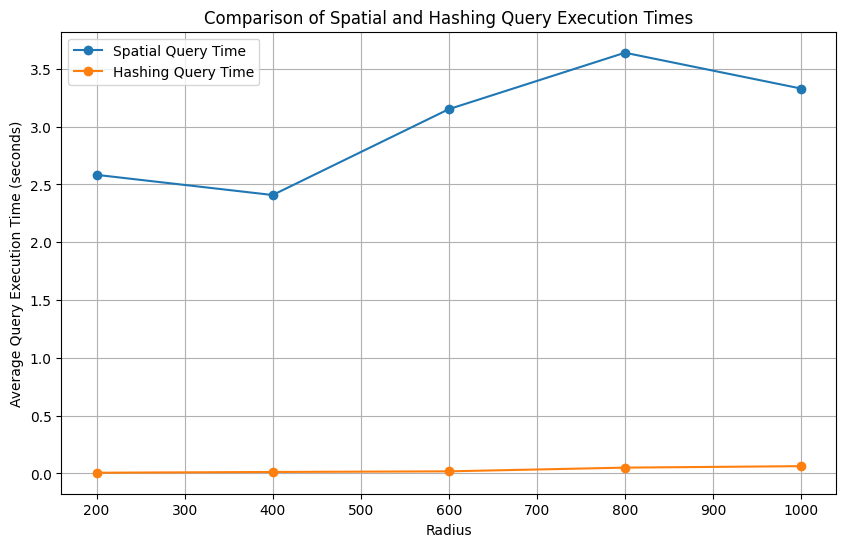

In [ ]:
import matplotlib.pyplot as plt

# Define the radii to test
radii = [200, 400, 600, 800, 1000]
spatial_times = []
hashing_times = []

# Iterate over each radius
for radius in radii:
    spatial_time = 0
    hashing_time = 0
    
    # Iterate over each point in the dataframe
    for _, row in df.iterrows():
        
        center_lat = row['lat']
        center_lon = row['lon']
        #print(center_lat, center_lon)
        # Spatial query
        spatial_query = f"SELECT COUNT(*) FROM points WHERE DistanceWithin(geometry, MakePoint({center_lon}, {center_lat}, 4326),{radius});"
        start_time = time.perf_counter()
        spatial_df = pd.read_sql(spatial_query, conn)
        end_time = time.perf_counter()
        spatial_time += (end_time - start_time)
        
        # Hashing query
        hashing_query = f"SELECT  COUNT(*) FROM points WHERE rowid IN (SELECT rowid FROM my_points_h3_index9 WHERE h3 = h3Neighbors(geoToH3({center_lat}, {center_lon}, 9), {radius/200}));"
        start_time = time.perf_counter()
        hashing_df = pd.read_sql(hashing_query, conn)
        end_time = time.perf_counter()
        hashing_time += (end_time - start_time)
    
    # Average the times for the current radius
    print('spatial_time', spatial_time)
    print('hashing_time', hashing_time)
    spatial_times.append(spatial_time / len(df))
    hashing_times.append(hashing_time / len(df))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(radii, spatial_times, label='Spatial Query Time', marker='o')
plt.plot(radii, hashing_times, label='Hashing Query Time', marker='o')
plt.xlabel('Radius')
plt.ylabel('Average Query Execution Time (seconds)')
plt.title('Comparison of Spatial and Hashing Query Execution Times')
plt.legend()
plt.grid()
plt.show()

In [14]:
print("Spatial query times:", spatial_times)
print("Hashing query times:", hashing_times)

Spatial query times: [2.5830089807691157, 2.408422847307632, 3.15096865461612, 3.63923278230745, 3.329409060769551]
Hashing query times: [0.006550795385108079, 0.013033514615884857, 0.01845253192351755, 0.050632703461451455, 0.06325808769240841]
